In [1]:
import pandas as pd
import numpy as np
import os, sys, glob, json
import h5py
import pickle
import uproot
import matplotlib
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)
    
from sklearn.model_selection import train_test_split

from modules.data_import import *
from modules.basics import *
from modules.model_export import *
from modules.features import *

from lumin.plotting import plot_settings
import seaborn as sns
from lumin.plotting.plot_settings import PlotSettings
from lumin.plotting.data_viewing import plot_feat

In [2]:
def read_root_file(filename, tree_name, features):
    root_file = uproot.open(filename)
    tree = root_file[tree_name]
    return tree.arrays(features, library="pd")

In [3]:
data_dir = '/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/'
stat_dir = '/data_CMS/cms/vernazza/cmt/MergeCategorizationStats/ul_2018_ZZ_v10/'

cont_feat = ['dnn_CvsB_b1', 'dnn_CvsL_b1', 'ZZKinFit_chi2', 'ZZKinFit_mass', 'Ztt_mass',
            'dnn_dR_l1_l2_x_sv_pT', 'dnn_dau1_mt', 'dau2_pt', 'dnn_dR_l1_l2', 'dnn_dphi_sv_met', 'Zbb_mass',
            'dnn_HHbtag_b2', 'ZZ_svfit_mass', 'dnn_dphi_Zbb_sv', 'Zbb_pt', 'dnn_dR_l1_l2_boosted_Ztt_met',
            'dau1_pt', 'dnn_bjet1_pt', 'dnn_Phi', 'dnn_costheta_l2_Zttmet']
cat_feat  = ['event', 'isBoosted', 'pairType', 'dnn_deepFlav1', 'dnn_deepFlav2', 'VBFjet1_JetIdx']
weights   = ['genWeight', 'puWeight', 'prescaleWeight', 'trigSF', 'L1PreFiringWeight_Nom', 'PUjetID_SF']

features = cont_feat + cat_feat + weights

In [4]:
sig_sample = 'zz_sl_signal'
sig_XS = 5.52 * 0.046
files_sig = glob.glob(data_dir + sig_sample + '/cat_base_selection/prod_DNN_Ellipse80/data_*.root')
print(" ### INFO: Reading signal samples for", sig_sample)
data_frames = [read_root_file(filename, 'Events', features) for filename in files_sig]
df_sig = pd.concat(data_frames, ignore_index=True)
stat_file = stat_dir + sig_sample + '_aux/prod_230718/stats.json'
with open(stat_file, "r") as f: 
    data = json.load(f)
    nevents = data['nevents']
    nweightedevents = data['nweightedevents']
df_sig['xs']         = sig_XS
df_sig['nev']        = nevents
df_sig['nev_w']      = nweightedevents
df_sig['gen_weight'] = df_sig['genWeight'] * df_sig['puWeight']
df_sig['cor_weight'] = df_sig['prescaleWeight'] * df_sig['trigSF'] * df_sig['L1PreFiringWeight_Nom'] * df_sig['PUjetID_SF']
df_sig['sample']     = sig_sample
del data_frames

 ### INFO: Reading signal samples for zz_sl_signal


In [5]:
bkg_samples_dict = { 
    'dy': 6077.22,
    'ggf_sm': 0.03105,
    'st_antitop': 80.95,
    'st_top': 136.02,
    'tt_dl': 88.29,
    'tt_fh': 377.96,
    'tth_bb': 0.2953,
    'tth_nonbb': 0.17996,
    'tt_sl': 365.34, 
    'wjets': 61526.7, 
    'zz_dl': 1.26, 
    'zz_fh': 3.262, 
    'zz_lnu': 0.564, 
    'zz_qnu': 4.07, 
    'zz_sl_background': 5.52*0.954,
    'zzz': 0.0147
}

In [6]:
df_all_bkg = pd.DataFrame()
for bkg_sample in bkg_samples_dict.keys():
    files_bkg = glob.glob(data_dir + bkg_sample + '/cat_base_selection/prod_DNN_Ellipse80/data_*.root')
    if '/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_2.root' in files_bkg:
        files_bkg.remove('/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_2.root')
    if '/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_1.root' in files_bkg:
        files_bkg.remove('/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10_backup/wjets/cat_base_selection/prod_DNN_Ellipse80/data_1.root')
    print(" ### INFO: Reading background samples for", bkg_sample)
    data_frames = [read_root_file(filename, 'Events', features) for filename in files_bkg]
    df_bkg = pd.concat(data_frames, ignore_index=True)
    stat_file = stat_dir + bkg_sample + '_aux/prod_230718/stats.json' if bkg_sample != 'dy' else stat_dir + 'dy_nlo_aux/prod_230718/stats.json'
    with open(stat_file, "r") as f: 
        data = json.load(f)
        nevents = data['nevents']
        nweightedevents = data['nweightedevents']
    df_bkg['xs']         = bkg_samples_dict[bkg_sample]
    df_bkg['nev']        = nevents
    df_bkg['nev_w']      = nweightedevents
    df_bkg['gen_weight'] = df_bkg['genWeight'] * df_bkg['puWeight']
    df_bkg['cor_weight'] = df_bkg['prescaleWeight'] * df_bkg['trigSF'] * df_bkg['L1PreFiringWeight_Nom'] * df_bkg['PUjetID_SF']
    df_bkg['sample']     = bkg_sample
    df_all_bkg = pd.concat([df_all_bkg, df_bkg], ignore_index=True)
    del data_frames

 ### INFO: Reading background samples for dy
 ### INFO: Reading background samples for ggf_sm
 ### INFO: Reading background samples for st_antitop
 ### INFO: Reading background samples for st_top
 ### INFO: Reading background samples for tt_dl
 ### INFO: Reading background samples for tt_fh
 ### INFO: Reading background samples for tth_bb
 ### INFO: Reading background samples for tth_nonbb
 ### INFO: Reading background samples for tt_sl
 ### INFO: Reading background samples for wjets
 ### INFO: Reading background samples for zz_dl
 ### INFO: Reading background samples for zz_fh
 ### INFO: Reading background samples for zz_lnu
 ### INFO: Reading background samples for zz_qnu
 ### INFO: Reading background samples for zz_sl_background
 ### INFO: Reading background samples for zzz


In [7]:
df_sig['Class'] = 0
df_all_bkg['Class'] = 1

Events = pd.concat([df_sig, df_all_bkg])
Events['weight'] = Events['gen_weight'] * Events['cor_weight']

# Input statistics

In [8]:
print('Signal size = \t\t',len(df_sig))
print('Background size = \t', len(df_all_bkg))

Signal size = 		 20007
Background size = 	 13412726


In [9]:
ss = sorted(Events['sample'].unique())
cs = sorted(Events['pairType'].unique())

pt = PrettyTable(['Sample']+[c for c in cs] + ['Tot'])
for s in ss:
    vs = []
    for c in cs: vs.append(len(Events[(Events['sample'] == s)&(Events['pairType']==c)]))
    vs.append(len(Events[(Events['sample'] == s)]))
    pt.add_row([s]+vs)
for c in cs: pt.align[c] = "l"
pt.align['Tot'] = 'l'
print(pt)

+------------------+---------+---------+-------+---------+
|      Sample      |    0    |    1    |   2   | Tot     |
+------------------+---------+---------+-------+---------+
|        dy        |  96616  |  76233  | 14272 | 187121  |
|      ggf_sm      |  13933  |   8745  | 10045 | 32723   |
|    st_antitop    |  57377  |  27807  |  588  | 85772   |
|      st_top      |  148374 |  72411  |  1714 | 222499  |
|      tt_dl       | 1727682 | 1070694 | 17234 | 2815610 |
|      tt_fh       |  19067  |   4283  | 16570 | 39920   |
|      tt_sl       | 6017276 | 3772530 | 45197 | 9835003 |
|      tth_bb      |   1638  |   1045  |   22  | 2705    |
|    tth_nonbb     |  10096  |   6497  |  1014 | 17607   |
|      wjets       |   3140  |   1806  |   22  | 4968    |
|      zz_dl       |  56270  |  43079  |  5481 | 104830  |
|      zz_fh       |    21   |    8    |   49  | 78      |
|      zz_lnu      |  22729  |  19627  |  6709 | 49065   |
|      zz_qnu      |    16   |    8    |   50  | 74     

#### Remove zero weights

In [10]:
pt = PrettyTable(['Sample']+[c for c in cs])
for s in ss:
    vs = []
    for c in cs:
        n = len(Events[(Events['sample'] == s)&(Events['pairType'] == c)&(Events['weight'] == 0)])
        d = len(Events[(Events['sample'] == s)&(Events['pairType'] == c)])
        try: ratio = n/d*100 
        except: ratio = 0
        vs.append("{:.2f}%".format(ratio))
    pt.add_row([s]+vs)
for c in cs: pt.align[c] = "l"
print(pt)

+------------------+-------+-------+-------+
|      Sample      |   0   |   1   |   2   |
+------------------+-------+-------+-------+
|        dy        | 0.00% | 0.00% | 0.42% |
|      ggf_sm      | 0.00% | 0.00% | 0.77% |
|    st_antitop    | 0.00% | 0.00% | 1.19% |
|      st_top      | 0.00% | 0.00% | 1.58% |
|      tt_dl       | 0.00% | 0.00% | 1.11% |
|      tt_fh       | 0.00% | 0.00% | 0.76% |
|      tt_sl       | 0.00% | 0.00% | 1.06% |
|      tth_bb      | 0.00% | 0.00% | 9.09% |
|    tth_nonbb     | 0.00% | 0.00% | 1.87% |
|      wjets       | 0.00% | 0.00% | 0.00% |
|      zz_dl       | 0.00% | 0.00% | 0.20% |
|      zz_fh       | 0.00% | 0.00% | 0.00% |
|      zz_lnu      | 0.00% | 0.00% | 0.25% |
|      zz_qnu      | 0.00% | 0.00% | 0.00% |
| zz_sl_background | 0.00% | 0.00% | 0.50% |
|   zz_sl_signal   | 0.00% | 0.00% | 0.53% |
|       zzz        | 0.00% | 0.00% | 0.86% |
+------------------+-------+-------+-------+


#### Remove negative weights

In [11]:
pt = PrettyTable(['Sample']+[c for c in cs])
for s in ss:
    vs = []
    for c in cs:
        n = len(Events[(Events['sample'] == s)&(Events['pairType'] == c)&(Events['weight'] < 0)])
        d = len(Events[(Events['sample'] == s)&(Events['pairType'] == c)])
        try: ratio = n/d*100 
        except: ratio = 0
        vs.append("{:.2f}%".format(ratio))
    pt.add_row([s]+vs)
for c in cs: pt.align[c] = "l"
print(pt)

+------------------+--------+--------+--------+
|      Sample      |   0    |   1    |   2    |
+------------------+--------+--------+--------+
|        dy        | 30.33% | 30.30% | 30.12% |
|      ggf_sm      | 0.00%  | 0.00%  | 0.00%  |
|    st_antitop    | 4.34%  | 4.55%  | 4.93%  |
|      st_top      | 4.46%  | 4.65%  | 4.03%  |
|      tt_dl       | 0.20%  | 0.19%  | 0.17%  |
|      tt_fh       | 0.26%  | 0.35%  | 0.37%  |
|      tt_sl       | 0.21%  | 0.22%  | 0.30%  |
|      tth_bb      | 0.49%  | 0.48%  | 0.00%  |
|    tth_nonbb     | 0.79%  | 0.80%  | 1.28%  |
|      wjets       | 0.00%  | 0.00%  | 0.00%  |
|      zz_dl       | 0.23%  | 0.22%  | 0.11%  |
|      zz_fh       | 4.76%  | 12.50% | 22.45% |
|      zz_lnu      | 0.09%  | 0.09%  | 0.03%  |
|      zz_qnu      | 12.50% | 37.50% | 24.00% |
| zz_sl_background | 22.78% | 21.89% | 22.60% |
|   zz_sl_signal   | 22.94% | 22.62% | 24.29% |
|       zzz        | 5.27%  | 7.16%  | 5.17%  |
+------------------+--------+--------+--

In [12]:
Events = Events[Events['weight'] > 0]

# NaN replacement

In [13]:
Events.replace([np.inf, -np.inf], np.nan, inplace=True)
fix = Events[cont_feat].columns[Events[cont_feat].isna().any()].tolist(); fix

['dnn_HHbtag_b2']

# Data Preprocessing

In [14]:
df_0 = Events[Events['event']%2 == 0] # even event numbers
df_1 = Events[Events['event']%2 != 0] # odd event numbers

In [15]:
savepath = Path('/data_CMS/cms/vernazza/FrameworkNanoAOD/DNNTraining/DNNInputs')
input_pipe_0 = fit_input_pipe(df_0, cont_feat, savepath/f'input_pipe_0')
input_pipe_1 = fit_input_pipe(df_1, cont_feat, savepath/f'input_pipe_1')

In [16]:
set_0_train = df_0.copy()
set_1_train = df_1.copy()
set_0_test = df_0.copy()
set_1_test = df_1.copy()

In [17]:
# train
set_0_train[cont_feat] = input_pipe_0.transform(set_0_train[cont_feat].values.astype('float32'))
set_1_train[cont_feat] = input_pipe_1.transform(set_1_train[cont_feat].values.astype('float32'))
# test
set_0_test[cont_feat] = input_pipe_1.transform(set_0_test[cont_feat].values.astype('float32'))
set_1_test[cont_feat] = input_pipe_0.transform(set_1_test[cont_feat].values.astype('float32'))

## Weight balancing

In [18]:
def check_weights(df:pd.DataFrame) -> None:
    v = []
    for c in [0, 1]:
        print('Class ', c)
        for m in df.pairType.unique():
            v.append(df.loc[(df.Class==c) & (df.pairType==m), 'weight'].sum())
            print(m, 'sum', v[-1])
    print(f' Channel std {np.std(v):.2f}')

def balance_weights(df:pd.DataFrame) -> None:
    df_copy = df.copy()
    print('\n Initial weight sums')
    check_weights(df_copy)
    for c in df_copy['pairType'].unique():
        for t in df_copy['Class'].unique():
            df_copy.loc[(df_copy['Class'] == t) & (df_copy['pairType'] == c), 'weight'] \
                /= np.sum(df_copy.loc[(df_copy['Class'] == t) & (df_copy['pairType'] == c), 'gen_weight'])
    print('\n Final weight sums')
    check_weights(df_copy)
    return df_copy

In [19]:
set_0_train_weight = balance_weights(set_0_train)


 Initial weight sums
Class  0
0 sum 34777.892653916315
1 sum 17138.177148685507
2 sum 9646.7283676386
Class  1
0 sum 1774981679.3113067
1 sum 1213546305.6675825
2 sum 120872453.78846164
 Channel std 710211912.00

 Final weight sums
Class  0
0 sum 0.9665911420265715
1 sum 0.9344921477099307
2 sum 0.9067382818617943
Class  1
0 sum 0.9666145338446863
1 sum 0.9417378102846625
2 sum 0.8899102685657536
 Channel std 0.03


In [20]:
set_1_train_weight = balance_weights(set_1_train)


 Initial weight sums
Class  0
0 sum 35157.05869528552
2 sum 10022.73273910042
1 sum 17078.94482589315
Class  1
0 sum 1778734358.5770802
2 sum 119726752.88124128
1 sum 1210159742.1636913
 Channel std 710875661.27

 Final weight sums
Class  0
0 sum 0.9663092255814276
2 sum 0.9038893334825974
1 sum 0.93659819005061
Class  1
0 sum 0.9666335891536911
2 sum 0.8916692292238878
1 sum 0.941821269981418
 Channel std 0.03


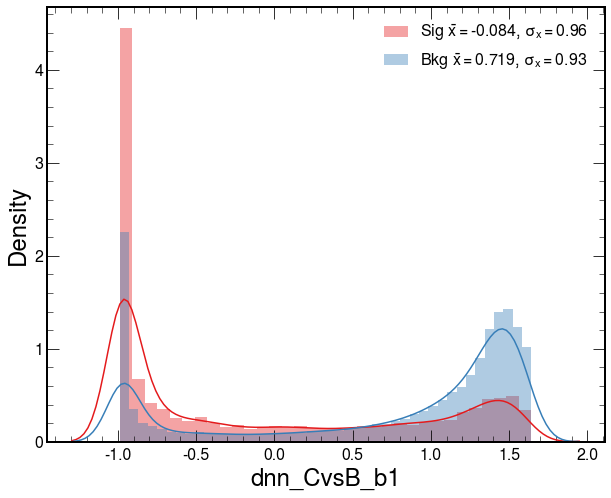

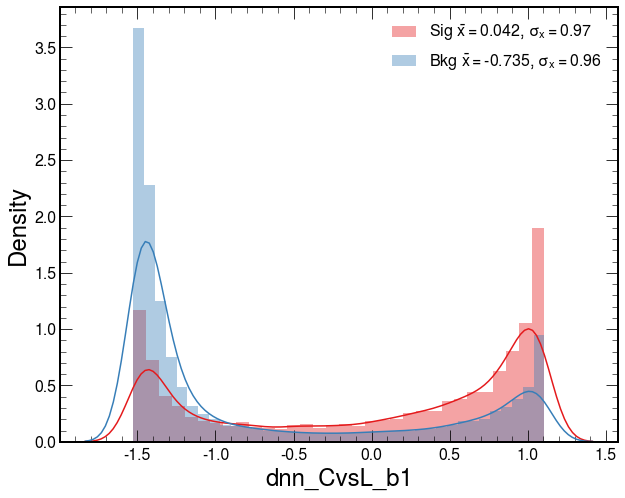

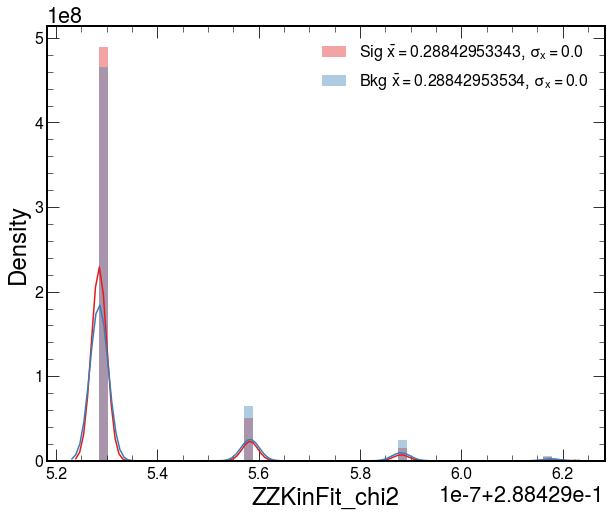

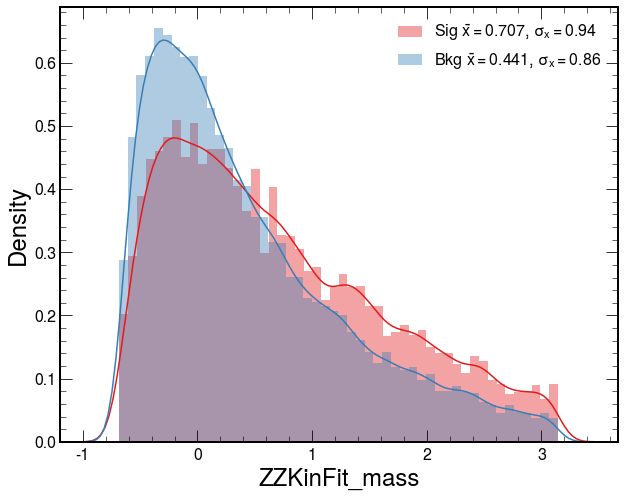

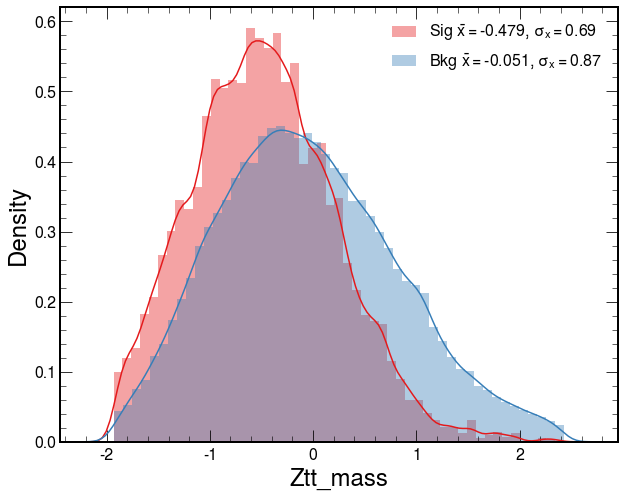

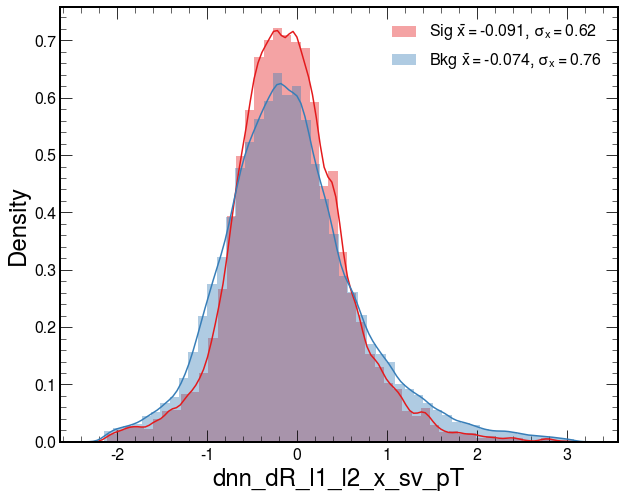

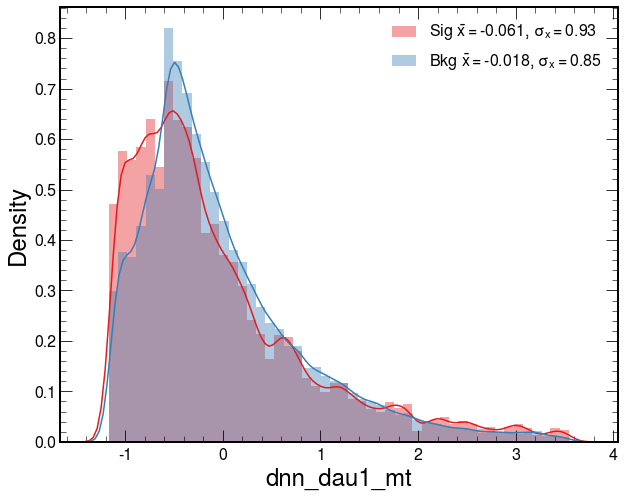

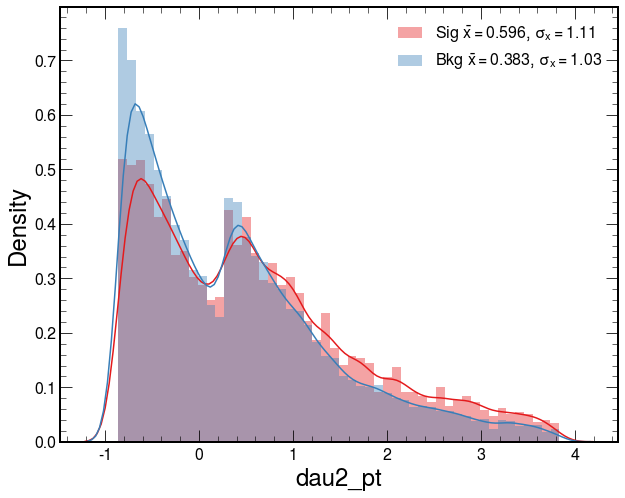

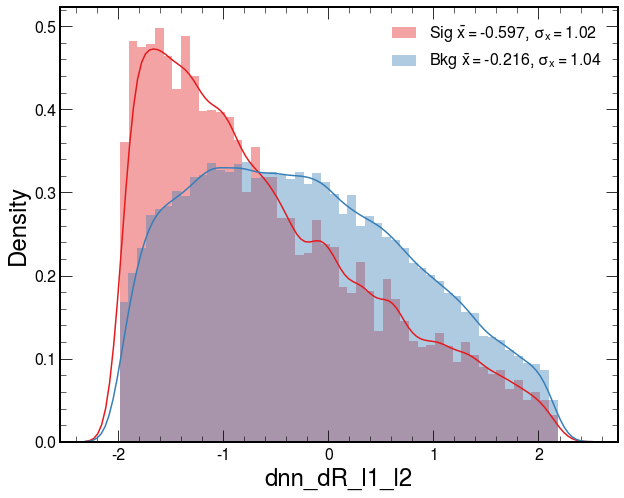

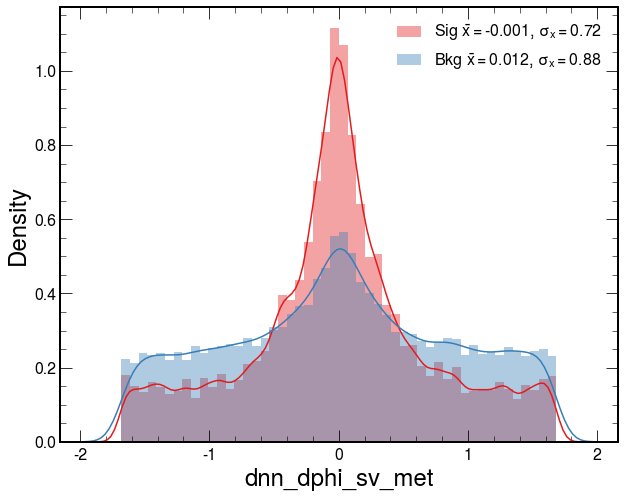

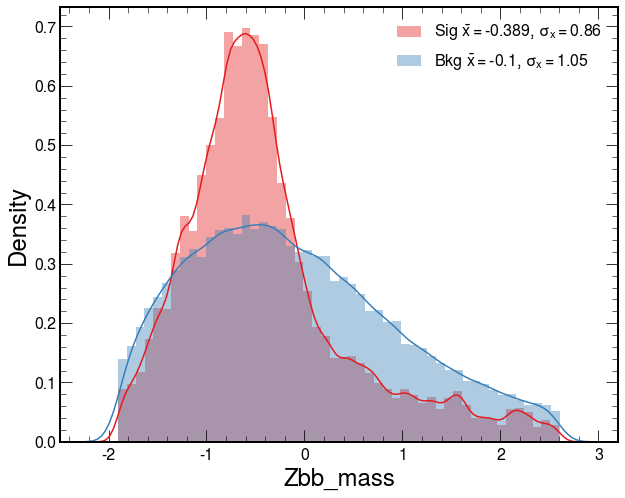

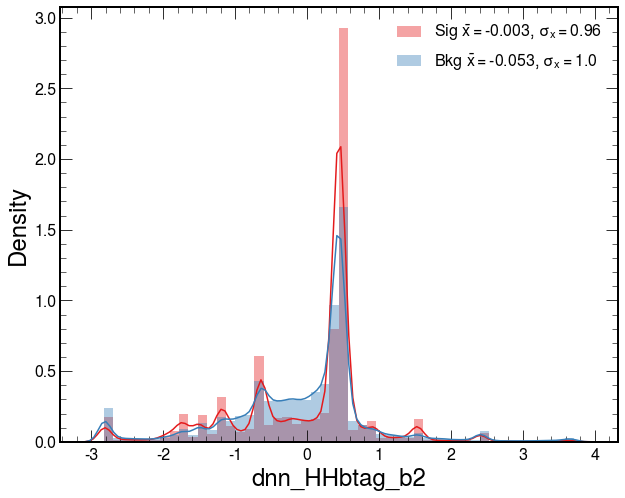

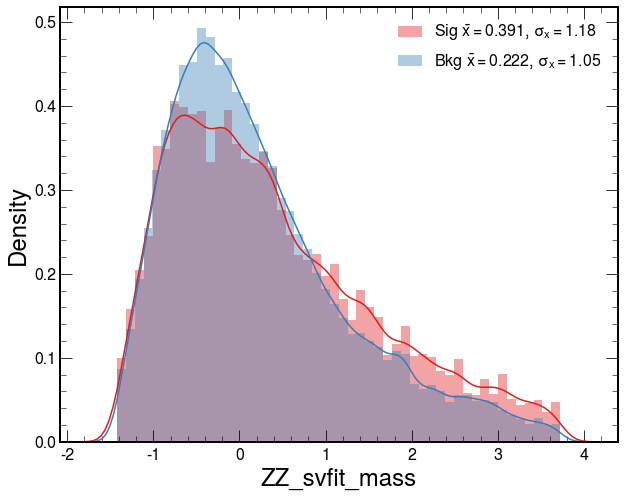

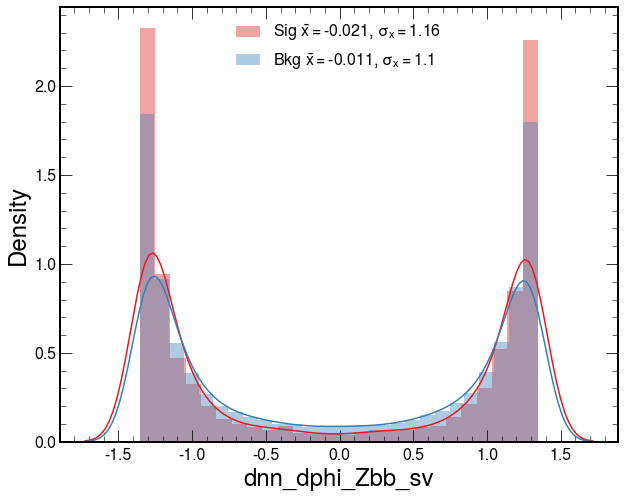

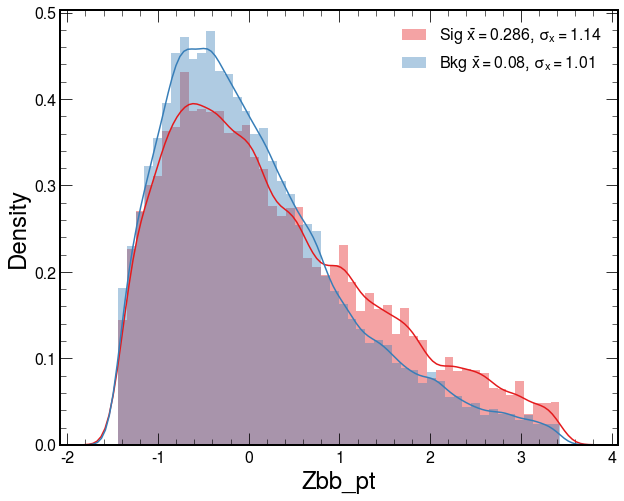

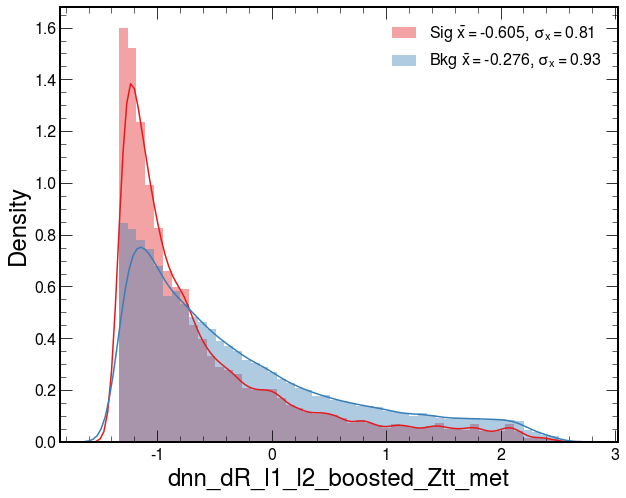

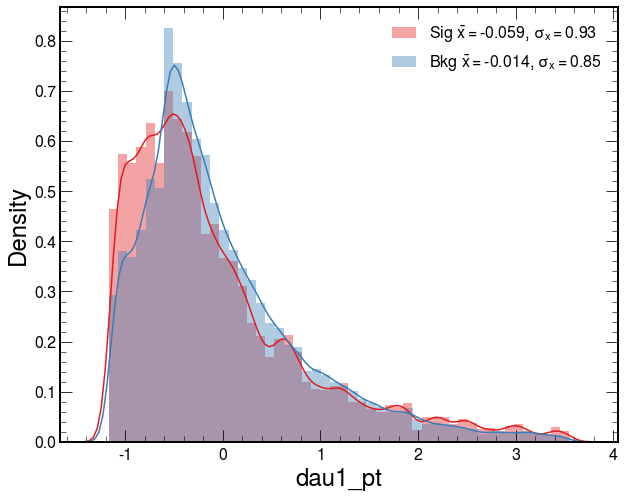

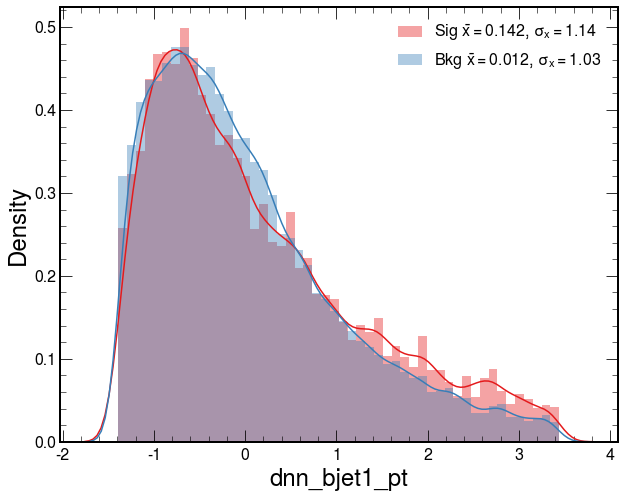

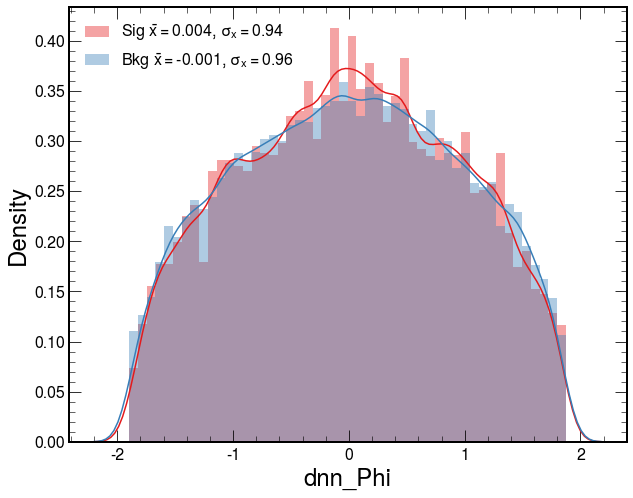

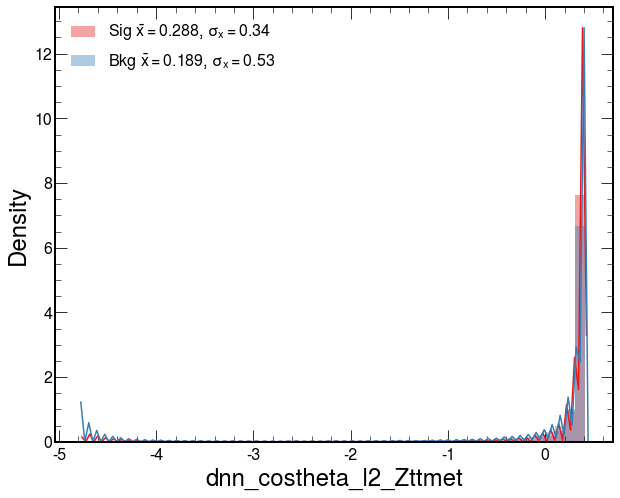

In [34]:
a = PlotSettings(w_mid=10, b_mid=10, cat_palette='Set1', style={})
for feature in cont_feat:
    plot_feat(set_0_train_weight, feature, cuts=[(set_0_train_weight.Class==0),(set_0_train_weight.Class>0)], \
              labels=['Sig','Bkg'], wgt_name='weight', settings=a)

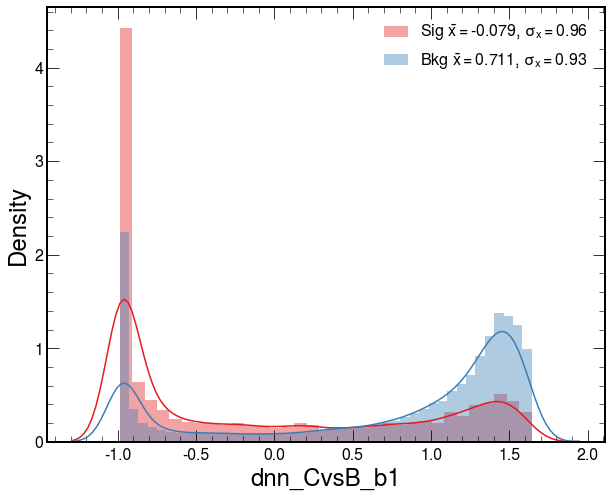

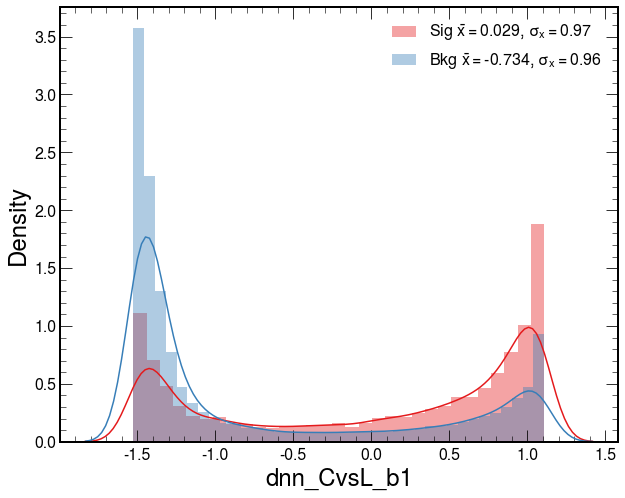

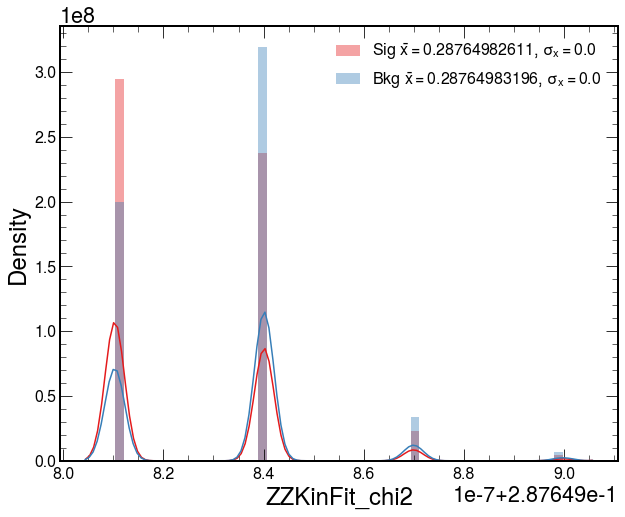

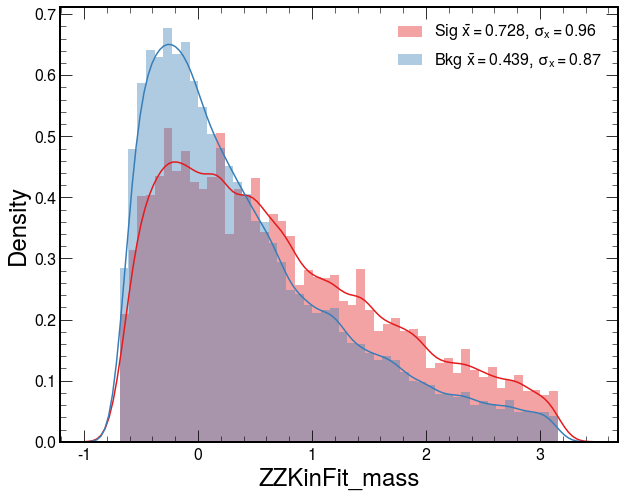

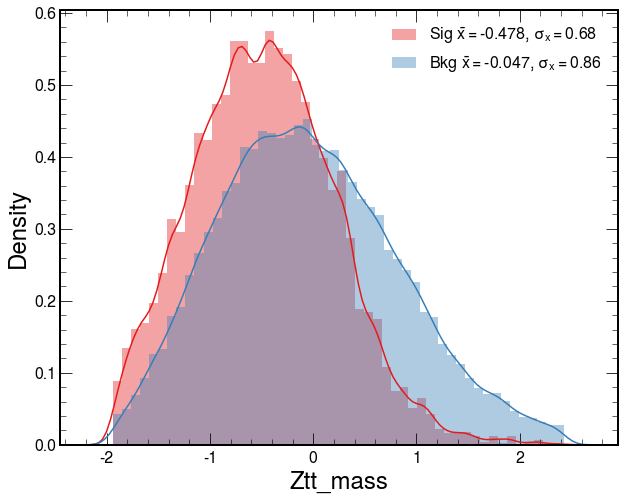

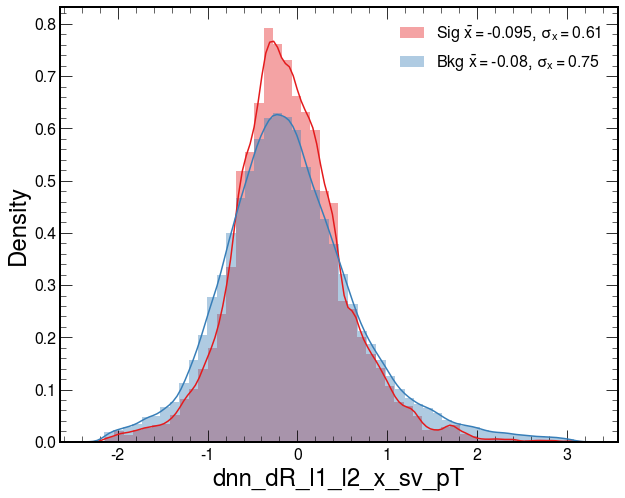

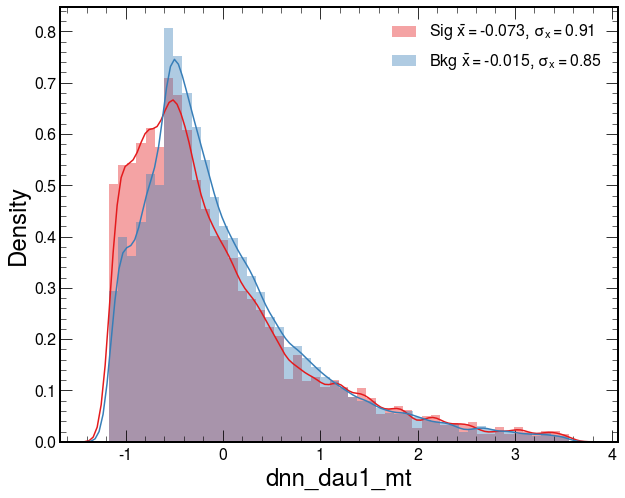

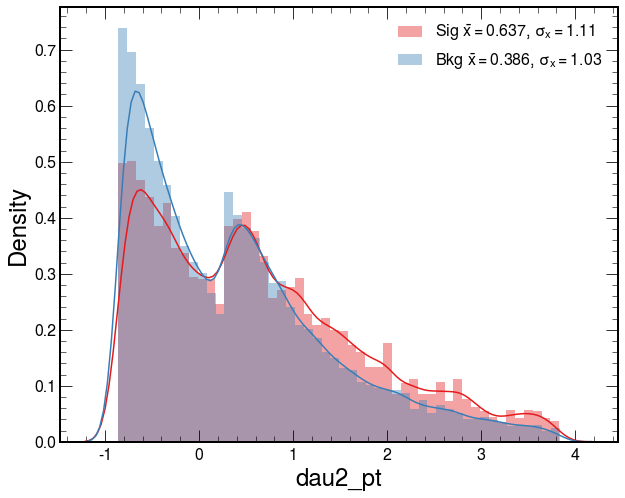

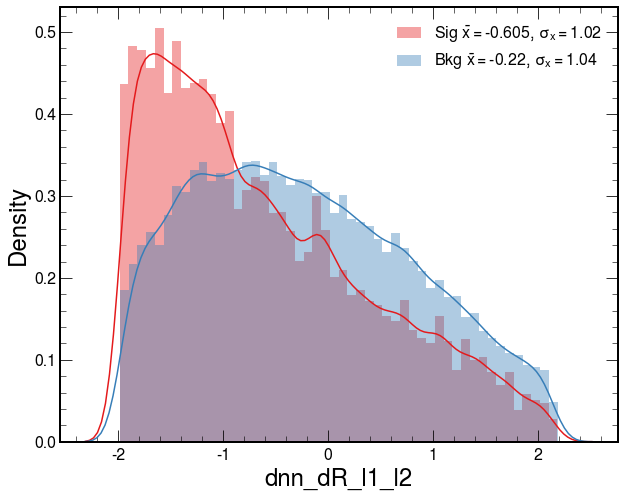

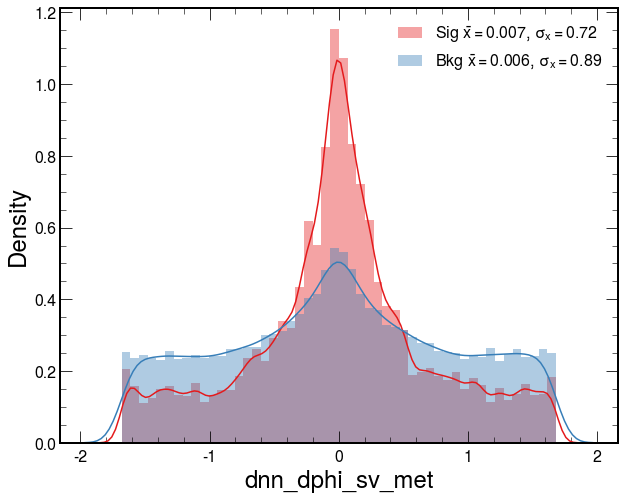

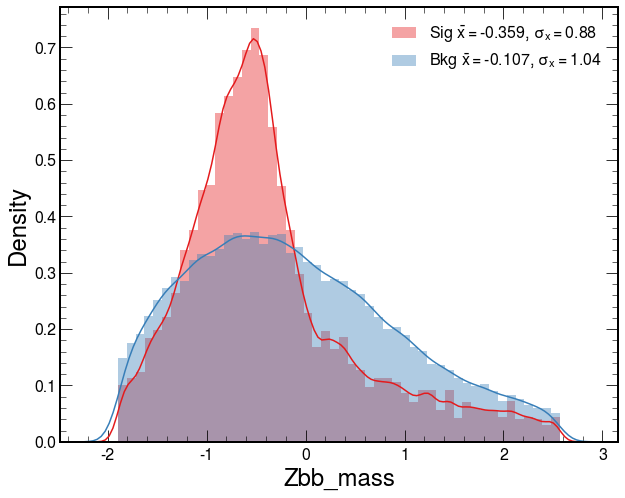

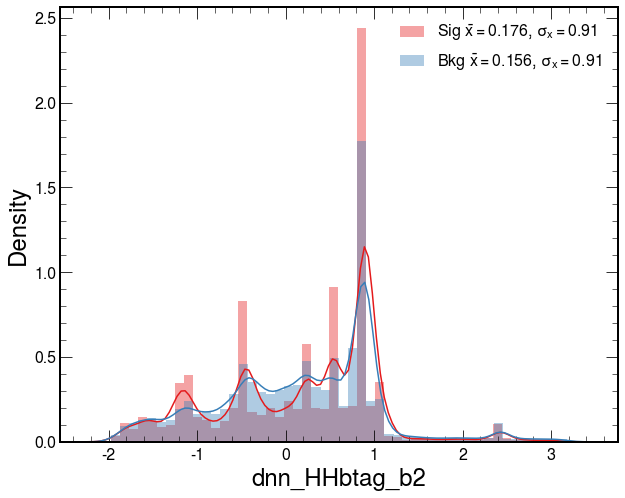

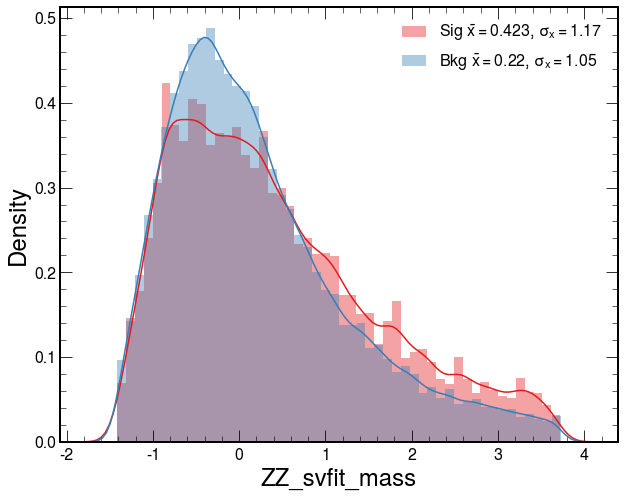

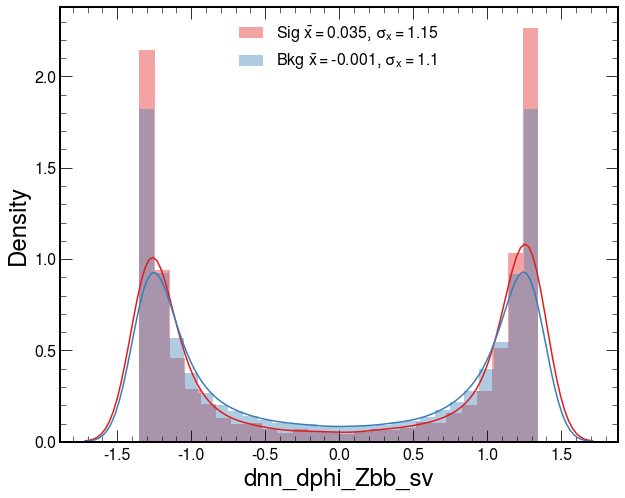

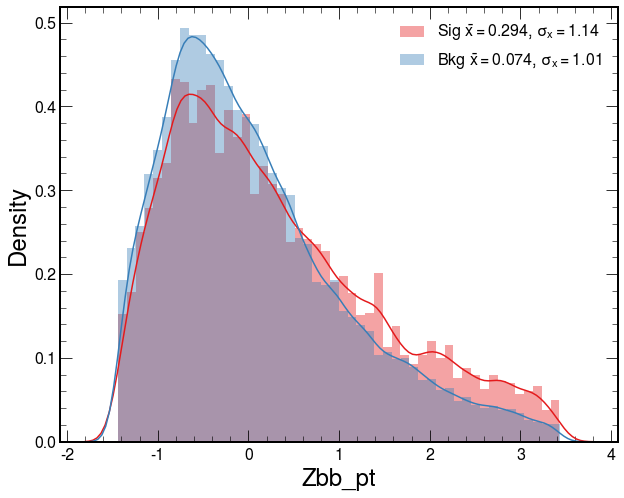

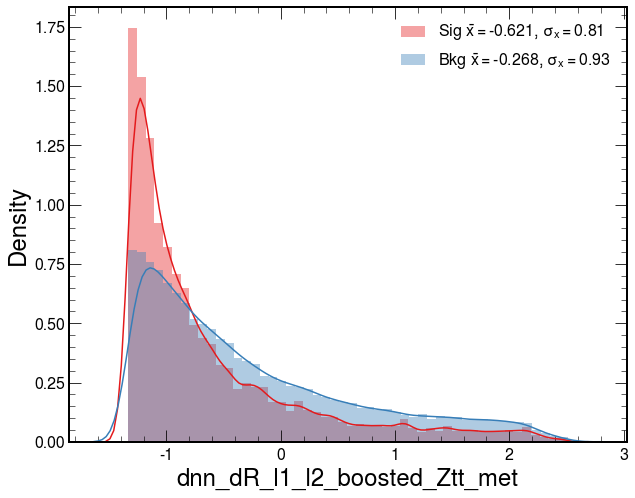

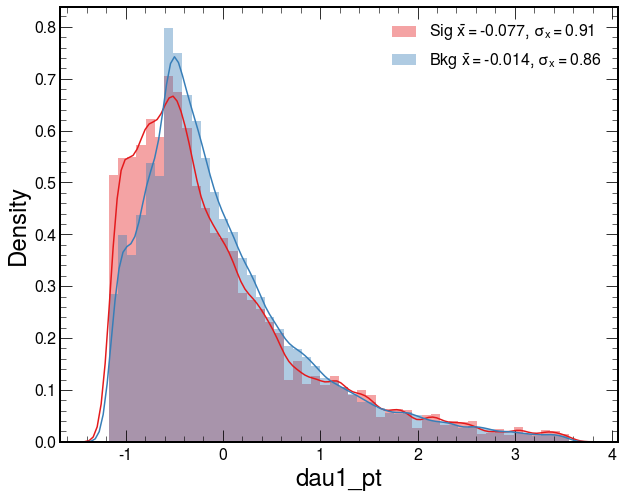

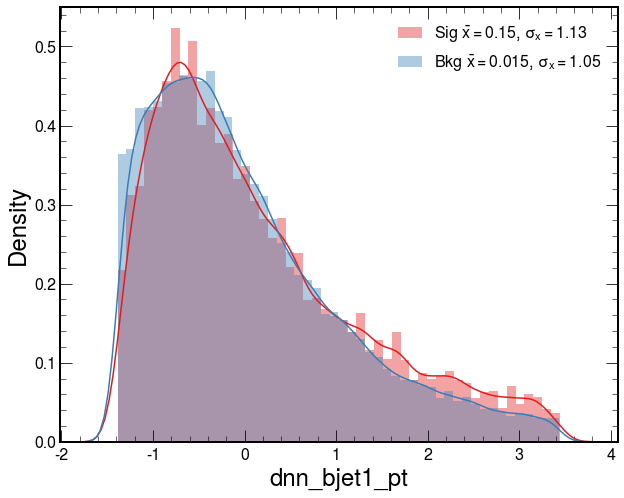

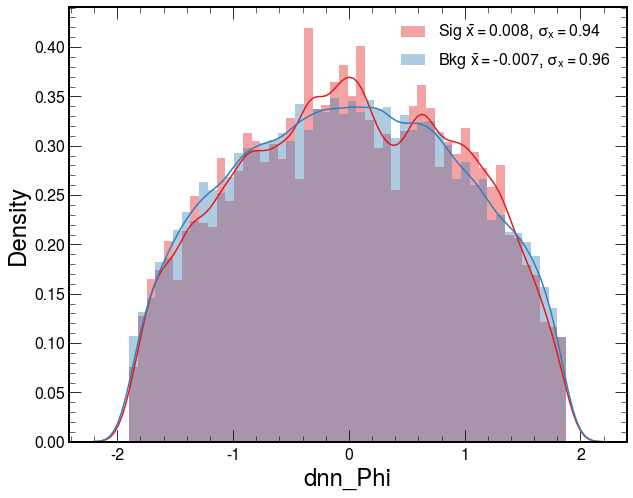

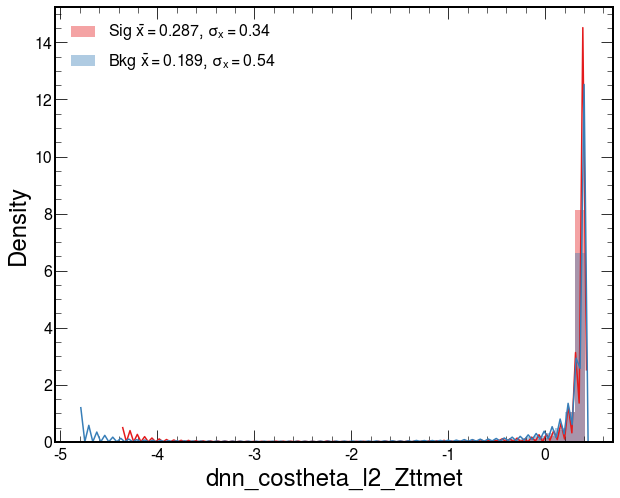

In [35]:
for feature in cont_feat:
    plot_feat(set_1_train_weight, feature, cuts=[(set_1_train_weight.Class==0),(set_1_train_weight.Class==1)], \
              labels=['Sig','Bkg'], wgt_name='weight', settings=a)

# Saving

In [ ]:
# df2foldfile(df=set_0_train_weight, n_folds=10,
#             cont_feats=cont_feat, cat_feats=cat_feat, targ_feats='Class', wgt_feat='weight',
#             misc_feats=['pairType', 'sample', 'gen_weight'],
#             savename=savepath/'train_0', targ_type='int')

In [ ]:
# df2foldfile(df=set_1_train_weight, n_folds=10,
#             cont_feats=cont_feat, cat_feats=cat_feat, targ_feats='Class', wgt_feat='weight',
#             misc_feats=['pairType', 'sample', 'gen_weight'],
#             savename=savepath/'train_1', targ_type='int')

In [ ]:
# df2foldfile(df=set_0_test, n_folds=10,
#             cont_feats=cont_feat, cat_feats=cat_feat, targ_feats='Class', wgt_feat='weight',
#             misc_feats=['pairType', 'sample', 'gen_weight'],
#             savename=savepath/'test_0', targ_type='int')

In [ ]:
# df2foldfile(df=set_1_test, n_folds=10,
#             cont_feats=cont_feat, cat_feats=cat_feat, targ_feats='Class', wgt_feat='weight',
#             misc_feats=['pairType', 'sample', 'gen_weight'],
#             savename=savepath/'test_1', targ_type='int')

# Weight testing

In [ ]:
sample = 'ggf_sm'
XS = 0.03105
files = ['/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10/ggf_sm/cat_base_selection/prod_230718/data_0.root']
data_frames = [read_root_file(filename, 'Events', features) for filename in files]
df1 = pd.concat(data_frames, ignore_index=True)
stat_file = stat_dir + sample + '_aux/prod_230718/stats.json'
with open(stat_file, "r") as f: 
    data = json.load(f)
    nevents = data['nevents']
    nweightedevents = data['nweightedevents']
MC_weight = XS/nweightedevents
df1['gen_weight'] = df1['genWeight'] * df1['puWeight']
df1['cor_weight'] = df1['prescaleWeight'] * df1['trigSF'] * df1['L1PreFiringWeight_Nom'] * df1['PUjetID_SF']
df1['sample'] = sample
del data_frames

In [ ]:
df1['gen_weight'].sum(), df1['genWeight'].sum(), df1['puWeight'].sum(), df1['cor_weight'].sum()

In [ ]:
sample = 'zzz'
XS = 0.0147
files = ['/data_CMS/cms/vernazza/cmt/PreprocessRDF/ul_2018_ZZ_v10/zzz/cat_base_selection/prod_230718/data_0.root']
data_frames = [read_root_file(filename, 'Events', features) for filename in files]
df2 = pd.concat(data_frames, ignore_index=True)
stat_file = stat_dir + sample + '_aux/prod_230718/stats.json'
with open(stat_file, "r") as f: 
    data = json.load(f)
    nevents = data['nevents']
    nweightedevents = data['nweightedevents']
MC_weight = XS/nweightedevents
df2['gen_weight'] = df2['genWeight'] * df2['puWeight']
df2['cor_weight'] = df2['prescaleWeight'] * df2['trigSF'] * df2['L1PreFiringWeight_Nom'] * df2['PUjetID_SF']
df2['sample'] = sample
del data_frames

In [ ]:
df2['gen_weight'].sum(), df2['genWeight'].sum(), df2['puWeight'].sum(), df2['cor_weight'].sum()